In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
torch.manual_seed(4)
np.random.seed(4)

In [2]:
BATCH_SIZE = 128
NUM_ITERS = int(2e4)
CRITERION = nn.CrossEntropyLoss()  


In [37]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,  transform=transform)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                        shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=2)

EPOCHS = int(NUM_ITERS / (len(trainset) / BATCH_SIZE))

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(DEVICE)

Files already downloaded and verified
Files already downloaded and verified
cuda


In [4]:

# Block

class ConvBlock(nn.Module):

    def __init__(self, stride=1, padding=1, batch_norm=False):
        super().__init__()
        self.batch_norm = batch_norm
        
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=stride, padding=padding)

        if batch_norm:
            self.bn1 = nn.BatchNorm2d(8)

        self.relu1 = nn.ReLU()        

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=stride, padding=padding)

        if batch_norm:
            self.bn2 = nn.BatchNorm2d(8)

        self.relu2 = nn.ReLU()       

         


    def forward(self, x):

        out = self.conv1(x)

        if self.batch_norm:
            out = self.bn1(out)

        out = self.relu1(out)

        out = self.conv2(x)

        if self.batch_norm:
            out = self.bn2(out)

        out = self.relu2(out)

        return out

# Model
class CNNModel(nn.Module):
    def __init__(self, batch_norm=False, N=10):

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=0)
        # Size: 28 x 28

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=2, padding=0)
        # Size: 12 x 12

        # Dynamic block num
        self.blocks = nn.Sequential(*[ConvBlock(batch_norm=batch_norm) for _ in range(N)])
        # Size: 12 x 12

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=0)                    
        # Size: 5 X 5

        self.fc1 = nn.Linear(5 * 5 * 4, 100, bias=True) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 10, bias=False) 


    def forward(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        
        out = self.blocks(out)         # How is the shape the same after this???
        out = self.conv3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)

        return out

In [5]:

def calc_accuracy(model, train=False): # add train param to calculate accuracy on both train and test
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    d_loader = train_loader if train else test_loader
    # Iterate through test dataset
    for images, labels in d_loader:
        # Load images
        images, labels = images.to(DEVICE), labels.to(DEVICE)        

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    return 100 * correct / total

def train(model): 
    print(f'Training for {EPOCHS} epochs')
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)  
    accuracy = {'train': [], 'test': []}

    for epoch in range(EPOCHS):    
        for i, (images, labels) in enumerate(train_loader): 
            # This will load batch_size amount of samples
            images, labels = images.requires_grad_().to(DEVICE), labels.to(DEVICE)                     

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = CRITERION(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

        train_accuracy = calc_accuracy(model, train=True) # abstract accuracy function away
        test_accuracy = calc_accuracy(model) # abstract accuracy function away
        # Print Loss
        print('Epoch: {} Loss: {}. Train Accuracy: {}, Test Accuracy: {}'.format(epoch, loss.item(), train_accuracy, test_accuracy))

        accuracy['train'].append(train_accuracy.item())
        accuracy['test'].append(test_accuracy.item())
        
    return pd.DataFrame(accuracy)

## a) Plot Train and Test accuracy

Training for 51 epochs
Epoch: 0 Loss: 2.3027138710021973. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 1 Loss: 2.3021628856658936. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 2 Loss: 2.302372455596924. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 3 Loss: 2.3020453453063965. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 4 Loss: 2.302574634552002. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 5 Loss: 2.30250883102417. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 6 Loss: 2.3025784492492676. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 7 Loss: 2.3028244972229004. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 8 Loss: 2.3024027347564697. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 9 Loss: 2.3030056953430176. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 10 Loss: 2.3030290603637695. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 11 Loss: 2.3028054237365723. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 12 Loss: 2.302643299102783. Train Accuracy: 10.0

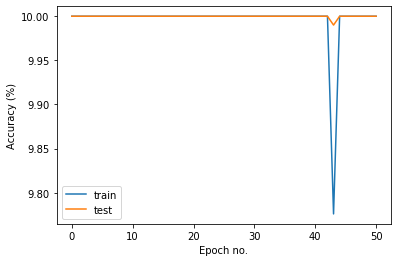

In [6]:

no_batch_norm = CNNModel().to(DEVICE)
nbn_history = train(no_batch_norm)
nbn_history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')

Training for 51 epochs
Epoch: 0 Loss: 1.940789818763733. Train Accuracy: 27.08599853515625, Test Accuracy: 27.649999618530273
Epoch: 1 Loss: 1.7568286657333374. Train Accuracy: 36.04199981689453, Test Accuracy: 36.05999755859375
Epoch: 2 Loss: 1.5260580778121948. Train Accuracy: 39.6359977722168, Test Accuracy: 39.63999938964844
Epoch: 3 Loss: 1.596287488937378. Train Accuracy: 41.343997955322266, Test Accuracy: 41.11000061035156
Epoch: 4 Loss: 1.6181385517120361. Train Accuracy: 43.72599792480469, Test Accuracy: 42.61000061035156
Epoch: 5 Loss: 1.3493764400482178. Train Accuracy: 45.301998138427734, Test Accuracy: 44.82999801635742
Epoch: 6 Loss: 1.4732204675674438. Train Accuracy: 46.32600021362305, Test Accuracy: 44.619998931884766
Epoch: 7 Loss: 1.6574041843414307. Train Accuracy: 47.25600051879883, Test Accuracy: 45.689998626708984
Epoch: 8 Loss: 1.3595701456069946. Train Accuracy: 47.36000061035156, Test Accuracy: 45.97999954223633
Epoch: 9 Loss: 1.2848687171936035. Train Accurac

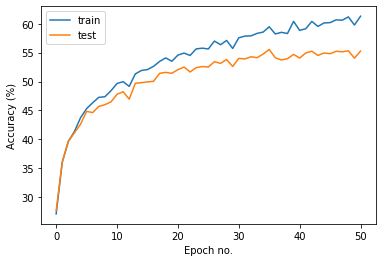

In [7]:
batch_norm = CNNModel(batch_norm=True).to(DEVICE)
bn_history = train(batch_norm)
bn_history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    

## b) Optimal value of N w/o batch normalization

Training for 51 epochs
Epoch: 0 Loss: 2.3076510429382324. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 1 Loss: 2.3001952171325684. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 2 Loss: 2.2752082347869873. Train Accuracy: 16.219999313354492, Test Accuracy: 16.10999870300293
Epoch: 3 Loss: 2.0460093021392822. Train Accuracy: 22.920000076293945, Test Accuracy: 23.76999855041504
Epoch: 4 Loss: 1.9569168090820312. Train Accuracy: 27.529998779296875, Test Accuracy: 28.389999389648438
Epoch: 5 Loss: 2.050244092941284. Train Accuracy: 29.104000091552734, Test Accuracy: 29.5
Epoch: 6 Loss: 1.9138145446777344. Train Accuracy: 31.229999542236328, Test Accuracy: 32.279998779296875
Epoch: 7 Loss: 1.9316638708114624. Train Accuracy: 30.807998657226562, Test Accuracy: 31.459999084472656
Epoch: 8 Loss: 1.7460505962371826. Train Accuracy: 33.7599983215332, Test Accuracy: 34.040000915527344
Epoch: 9 Loss: 1.7481815814971924. Train Accuracy: 35.06599807739258, Test Accuracy: 35.25
Epoch: 10 Loss: 

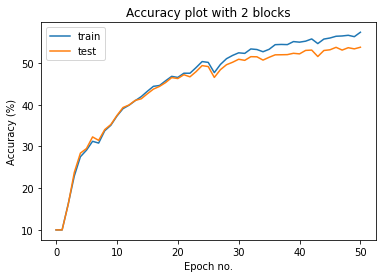

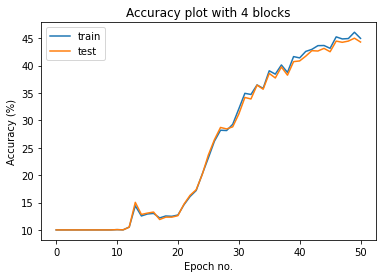

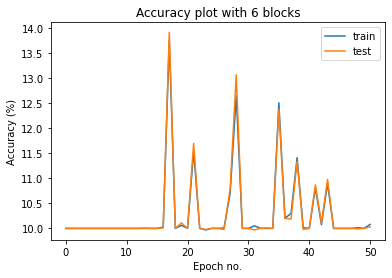

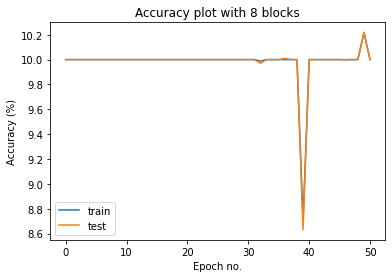

In [8]:
nbn_models = []
nbn_histories = []
for test_n in range(2, 10):
    if test_n % 2 == 0: # if it's even
        model = CNNModel(N=test_n).to(DEVICE)
        nbn_models.append(model)
        history = train(model)
        nbn_histories.append(history)
        history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
        plt.title(f'Accuracy plot with {test_n} blocks')
    


### Analysis

From these experiments, we can see that 2 is the optimal number of blocks with our CNN model without batch normalization. This was a little surprising to me, as I thought that increasing the depth of the model would directly correlate to better performance. However, we see that this really isn't the case because without batch normalization it will take many many more epocsh to converge.

## c) Plot 2 misclassified and 2 correctly classified samples for each class

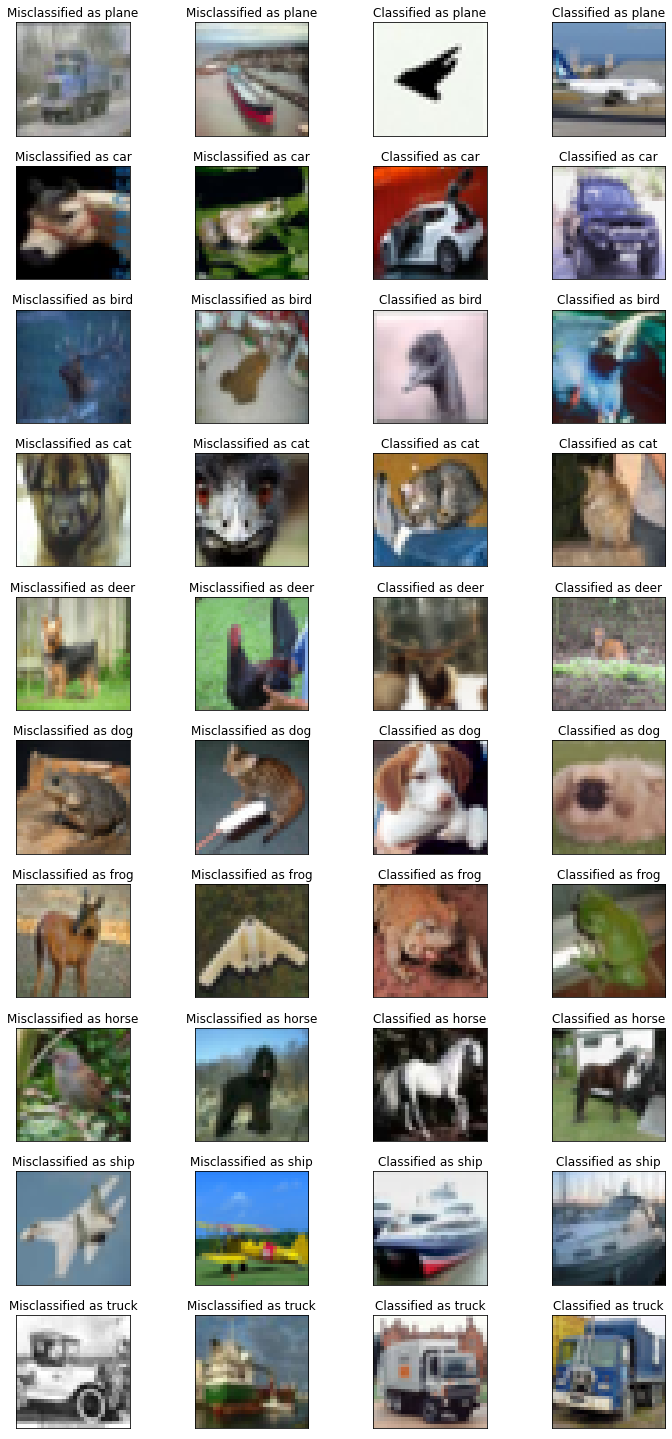

In [38]:


inv_normalize = transforms.Normalize(
  (-1, -1, -1),
  (2, 2, 2)
)

def plot_per_class(model):
  # Find 2 misclassified and 2 correclty classified test samples for each output class
  misclassified = {k: [] for k in range(10)}
  correctly_classified = {k: [] for k in range(10)}    

  for images, labels in test_loader:      
      images, labels = images.to(DEVICE), labels.to(DEVICE)        
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      for pred, act, image in zip(predicted, labels, images):
          if pred != act:
              misclassified[pred.item()].append(image) # save misclassified images
          else:
              correctly_classified[pred.item()].append(image) # save correctly classified

  fig=plt.figure(figsize=(10, 40))

  # Plot misclasssified and classified correctly
  for clas in range(10):
      for i in range(1, 3):
          img = inv_normalize(misclassified[clas][i].cpu()).numpy()
          img = np.dstack((img[0], img[1], img[2]))
          ax = fig.add_subplot(20, 4, clas * 4 + i)
          ax.set_xticks([])
          ax.set_yticks([])
          ax.set_title(f"Misclassified as {classes[clas]}")
          plt.imshow(img)
      for j in range(3, 5):
          img = inv_normalize(correctly_classified[clas][j-3].cpu()).numpy()
          img = np.dstack((img[0], img[1], img[2]))
          ax = fig.add_subplot(20, 4, clas * 4 + j)
          ax.set_xticks([])
          ax.set_yticks([])          
          ax.set_title(f"Classified as {classes[clas]}")
          plt.imshow(img)


  plt.tight_layout()
  plt.show()


best_nbn = nbn_models[0]

plot_per_class(best_nbn)

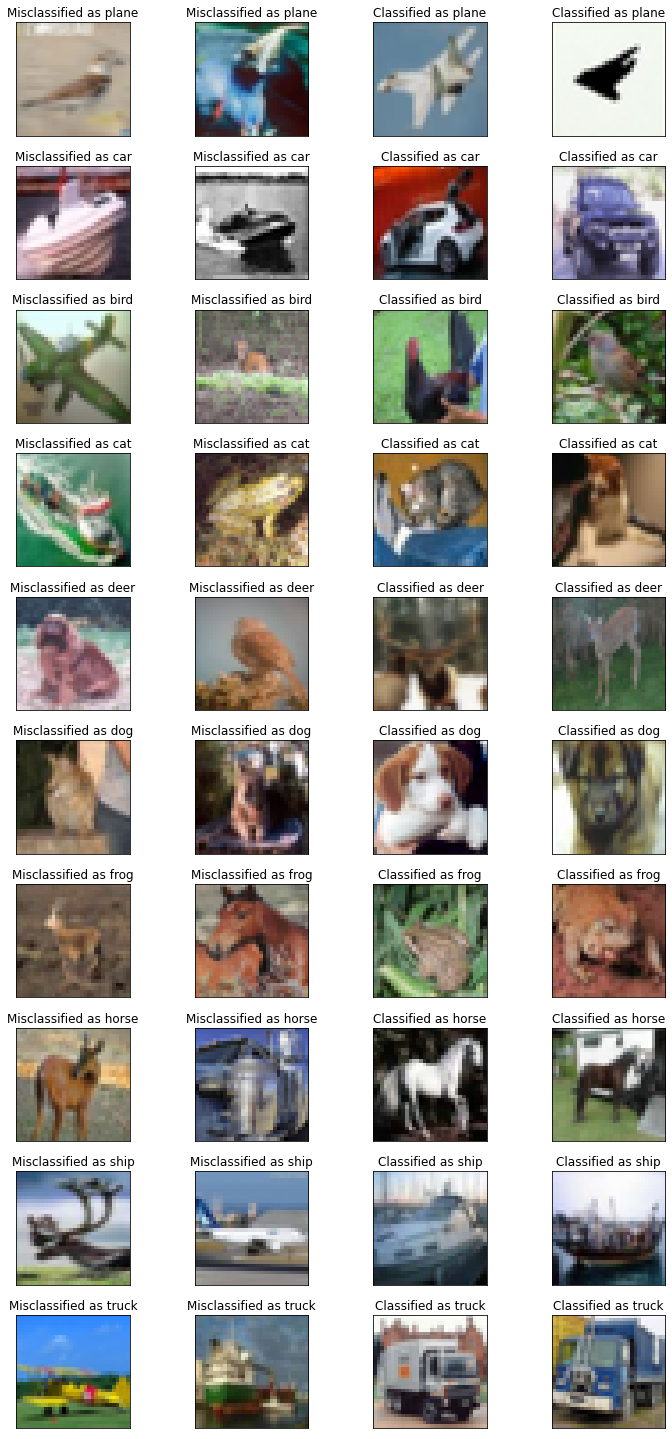

In [39]:
plot_per_class(batch_norm)

## d) Comparison with previous homework



On the last homework we used a similar CNN model on the CIFAR 10 dataset as well, but the accuracy received was tended to be much higher than the ones on this homework, which is not what I would expected. With the best model last homework, which only had two convolutional layers and one fully connected layer, we were able to achieve an accuracy of around 65%. In comparison, the best model we trained in this homework, the batch normalized with 10 blocks, was only able to achieve an accuracy of around 55%. Initially, I was tempted to draw this difference up to the fact that sense the batch size was much lower and the model was simpler, so it would be able to converge more quickly and this is where the accuracy difference was experienced. However, I realized that we only trained for 3 epochs in the last hoemwork whilst we trained for 51 epochs with these experiments. I'm not quite sure why such a stark difference in performance has been observed. I was expecting that a deeper model would be able to perform better. Maybe we need to train for many more epochs.